In [54]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

#### E01: 
I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. 
You might think either that 
1) the network trains just fine or 
2) the network doesn't train at all

but actually it is:

the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

We can start by modifying our Linear Module to initialize its weights and biases to zeros:

In [55]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True) -> None:
        self.weights = torch.zeros((fan_in, fan_out))
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x): # 'forward'
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weights, self.bias] if self.bias is not None else [self.weights]

class Tanh:
    def __init__(self) -> None:
        pass

    def __call__(self, x):
        self.out = x.tanh()
        return self.out

    def parameters(self):
        return []

Next we can construct a network and inspect the gradients and activations:

In [56]:
# dataset stuff

words = open('../l2_makemore/names.txt').read().splitlines()
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for i,c in enumerate(chars)}

def build_inputs_and_labels(words, block_size):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

def train_dev_test_split(words, train_size=0.8, dev_size=0.1):
    random.shuffle(words)
    assert train_size + dev_size < 1
    num_words = len(words)
    train_split = int(num_words * train_size)
    dev_split = int(num_words * (train_size + dev_size))
    train_words = words[:train_split]
    dev_words = words[train_split:dev_split]
    test_words = words[dev_split:]
    return train_words, dev_words, test_words


train_words, dev_words, test_words = train_dev_test_split(words)
block_size = 3
embedding_size = 10
hidden_layer_size = 100
num_chars = len(chars)
train_X, train_Y = build_inputs_and_labels(train_words, block_size=3)

In [57]:
embeddings = torch.randn((num_chars, embedding_size))
layers = [
    Linear(embedding_size * block_size, hidden_layer_size), 
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, num_chars)
]

parameters = [embeddings] + [p for layer in layers for p in layer.parameters()]
print(f'Number of Parameters: {sum(p.numel() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

Number of Parameters: 46497


Next, we can try running gradient descent for a few iterations to see what our gradients and activations look like using the techniques from lecture:

In [58]:
def forward(layers, embeddings, x):
    x = embeddings[x]
    x = x.view(x.shape[0], -1)
    for layer in layers:
        x = layer(x)
    return x

def optimize_step(x, y, layers, embeddings, parameters, lr, debug=False):
    for p in parameters:
        p.grad = None
    logits = forward(layers, embeddings, x)
    loss = torch.nn.functional.cross_entropy(logits, y)
    
    if debug:
        for layer in layers:
            layer.out.retain_grad()
    loss.backward()
    for p in parameters:
        p.data -= p.grad * lr
        
    return loss.item()

def gradient_descent(x, y, layers, embeddings, parameters, iterations, minibatch_size, lr, lr_decay, print_every, debug=False):
    losses = []
    ud = []
    for i in range(iterations):
        batch_indices = torch.randint(0, x.shape[0], (minibatch_size,))
        xi = x[batch_indices]
        yi = y[batch_indices]
        loss = optimize_step(xi, yi, layers, embeddings, parameters, lr, debug)
        losses.append(loss)
        with torch.no_grad():
            ud.append([(lr * p.grad.std() / p.data.std()).log().item() for p in parameters])
        if i % print_every == 0:
            print(f'Iteration {i} loss: {loss}')
        lr *= (1 - lr_decay)
    return losses, ud

In [59]:
losses, ud = gradient_descent(train_X, train_Y, layers, embeddings, parameters, iterations=1000, minibatch_size=128, lr=0.2, lr_decay=0.00002, print_every=10000, debug=True)

Iteration 0 loss: 3.295837163925171


We can see our loss decreases over the first few iterations, but does not converge to a value as low as other iterations of our model have converged to:

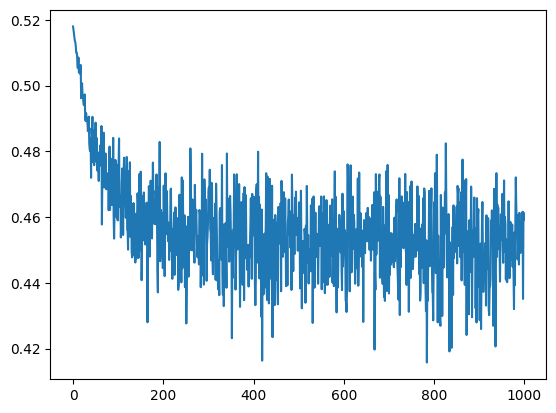

In [60]:
plt.plot(torch.tensor(losses).log10())
plt.show()

Let's figure out why our model is not training as well. To start, we can look at the activations coming out of each tanh layer, just as we did in lecture:

Layer 1 mean=+0.00, stddev=0.00, saturation=0.00%
Layer 3 mean=+0.00, stddev=0.00, saturation=0.00%
Layer 5 mean=+0.00, stddev=0.00, saturation=0.00%
Layer 7 mean=+0.00, stddev=0.00, saturation=0.00%
Layer 9 mean=+0.00, stddev=0.00, saturation=0.00%


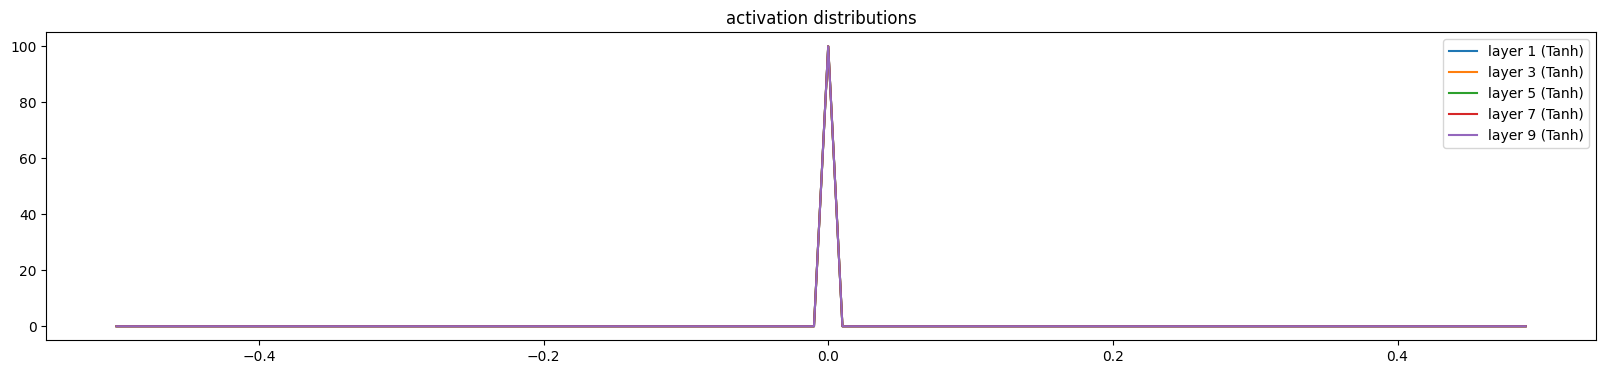

In [67]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            f'Layer {i} mean={t.mean():+.2f}, stddev={t.std():.2f}, saturation={(t.abs() > 0.97).float().mean()*100:.2f}%'
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distributions')
plt.show()

We can see that every single activation is zero... no wonder our network is not training well. But if all the tanh activations are zero, how is our network training at all? We did see loss go down, so something must be happening in the final layer.

Layer 9 mean=-0.00, stddev=1.02, saturation=40.74%


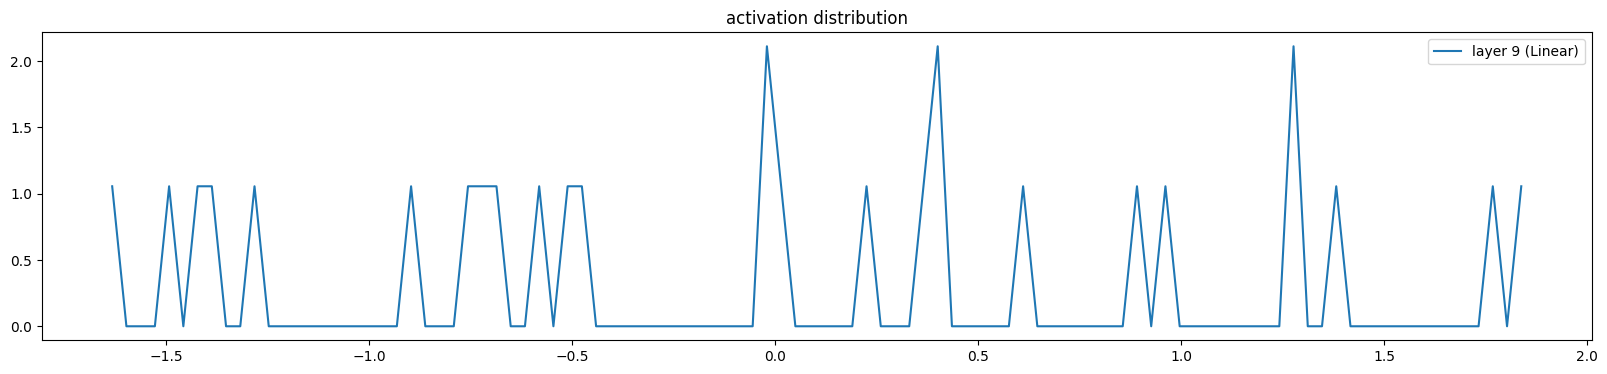

In [72]:
plt.figure(figsize=(20, 4))
legends = []
t = layer.out
hy, hx = torch.histogram(t, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
legends.append(f'layer {i} ({layer.__class__.__name__})')
print(
    f'Layer {i} mean={t.mean():+.2f}, stddev={t.std():.2f}, saturation={(t.abs() > 0.97).float().mean()*100:.2f}%'
)
plt.legend(legends)
plt.title('activation distribution')
plt.show()

We do see activations in this layer... let's check the gradients to get a better idea of what's going on:

weight shape=torch.Size([100, 27]) mean=+0.00000, stddev=0.00000, grad:data ratio=nan


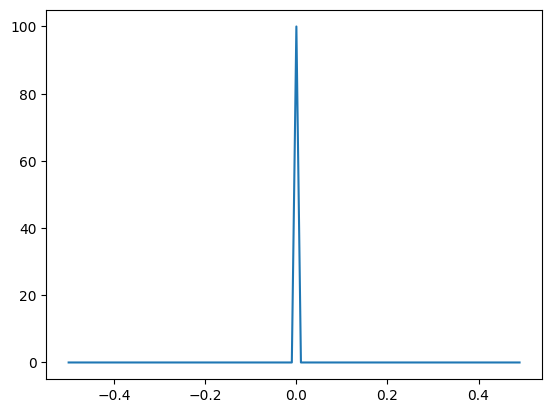

In [73]:
final_layer_weights, final_layer_bias = parameters[-2], parameters[-1]
t = final_layer_weights.grad
print(f'weight shape={final_layer_weights.shape} mean={t.mean():+.5f}, stddev={t.std():.5f}, grad:data ratio={(t.std() / final_layer_weights.std()):.5f}')
hy, hx = torch.histogram(t, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
legends.append(f'{i} {tuple(final_layer_weights.shape)}')


The layer's weights all have zero gradient, so something *must* be going on with the bias parameters...

weight shape=torch.Size([27]) mean=-0.00000, stddev=0.01396, grad:data ratio=0.01344


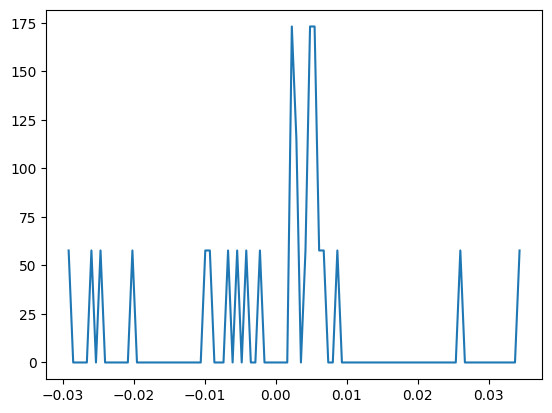

In [74]:
t = final_layer_bias.grad
print(f'weight shape={final_layer_bias.shape} mean={t.mean():+.5f}, stddev={t.std():.5f}, grad:data ratio={(t.std() / final_layer_bias.std()):.5f}')
hy, hx = torch.histogram(t, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
legends.append(f'{i} {tuple(final_layer_bias.shape)}')

Sure enough, the only signs of life in the network are in the bias parameters. Since these are the only paramters with gradient, our network is essentially learning a constant function y = b. If this is truly the case, we'd expect the network to learn to always pick the most common letters. Furthermore, we'd expect every network output to be identical regardless of input. We can verify:

In [81]:
forward(layers, embeddings, train_X[0:5])

tensor([[ 1.7960,  1.8784, -0.7158, -0.4685, -0.0077,  1.3796, -1.3640, -0.8776,
          0.4028,  1.2816, -0.5574,  0.0233,  0.9870,  0.2447,  1.2980,  0.4204,
         -1.2788, -1.6341,  0.9063,  0.4236,  0.0124, -0.5094, -0.6662, -1.3930,
         -1.4632,  0.6208, -0.7392],
        [ 1.7960,  1.8784, -0.7158, -0.4685, -0.0077,  1.3796, -1.3640, -0.8776,
          0.4028,  1.2816, -0.5574,  0.0233,  0.9870,  0.2447,  1.2980,  0.4204,
         -1.2788, -1.6341,  0.9063,  0.4236,  0.0124, -0.5094, -0.6662, -1.3930,
         -1.4632,  0.6208, -0.7392],
        [ 1.7960,  1.8784, -0.7158, -0.4685, -0.0077,  1.3796, -1.3640, -0.8776,
          0.4028,  1.2816, -0.5574,  0.0233,  0.9870,  0.2447,  1.2980,  0.4204,
         -1.2788, -1.6341,  0.9063,  0.4236,  0.0124, -0.5094, -0.6662, -1.3930,
         -1.4632,  0.6208, -0.7392],
        [ 1.7960,  1.8784, -0.7158, -0.4685, -0.0077,  1.3796, -1.3640, -0.8776,
          0.4028,  1.2816, -0.5574,  0.0233,  0.9870,  0.2447,  1.2980,  0.4204

Our intuition was correct!

And sure enough... 

In [82]:
forward(layers, embeddings, train_X[0:5])[0].argmax(dim=-1)

tensor(1)

In [86]:
counts = torch.zeros(num_chars)
for word in train_words:
    for c in word:
        counts[stoi[c]] += 1
print(itos[torch.argmax(counts).item()])

a


The most likely character simply becomes the most common one in the dataset!

But why are the output layer biases the only parameters with any gradient? 

Well...if we calculate the gradient of the final layer's weights, for a particular weight w the gradient becomes x (value of input) by the definition $\frac{d}{dw}w*x = x$, multiplied by the gradient of the loss function. Since the input value is zero, the gradient for each of the output layer weights becomes zero. Then... this gradient propogates back and since we are only using products and tanh throughout the network makes the gradients for each of the other linear layers zero. This phenomenon persists indefinitely because zero of the final output paramters can learn. This goes to show the importance of initializing weights to nonzero values in order to allow gradient to propogate. Even if we initialized the embeddings to nonzero values the phenomenon would persist.

### E02: 
BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

Let's review our batchnorm implementation from lecture:

In [98]:
class BatchNorm:
    def __init__(self, dim, eps=1e-6, momentum=0.1, training=True) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = training

        # gain and bias (gamma and beta)
        self.gain = torch.ones(dim)
        self.bias = torch.zeros(dim)

        # running mean and variance
        self.running_mean = torch.zeros(dim)
        self.running_variance = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            mean = x.mean(0, keepdim=True)
            variance = x.var(0, keepdim=True)
        else:
            mean = self.running_mean
            variance = self.running_variance
        
        xout = (x - mean) / torch.sqrt(variance + self.eps)
        self.out = (xout * self.gain) + self.bias

        if self.training:
            with torch.no_grad():
                self.running_mean = ((1 - self.momentum) * self.running_mean) + (self.momentum * mean)
                self.running_variance = ((1 - self.momentum) * self.running_variance) + (self.momentum * variance)
        
        return self.out
    
    def parameters(self):
        return [self.gain, self.bias]
        

We can see that during inference, our batchnorm layer output is given by 

$out=g_n * (\frac{(x-\mu)}{\sqrt{v + \epsilon}}) + b_n$

Then, substituting our previous layer's math, we get:

$out=g_n * (\frac{(w*x + b)-\mu)}{\sqrt{v + \epsilon}}) + b_n$

Which we can simplify to:


$out=(g_n * \frac{w}{\sqrt{v + \epsilon}}) * x + (g_n * \frac{b-\mu}{\sqrt{v + \epsilon}} + b_n)$

Which implies that in order to 'fold in' the batch normalization layer,

$w_2= (g_n * \frac{w}{\sqrt{v + \epsilon}}) $ and

$b_2= (g_n * \frac{b-\mu}{\sqrt{v + \epsilon}} + b_n)$

This becomes fairly trivial to implement:


In [107]:
def fold_in(linear_layer: Linear, batchnorm_layer: BatchNorm) -> Linear:
    linear_layer.weights.data = batchnorm_layer.gain.data * (linear_layer.weights.data / torch.sqrt(batchnorm_layer.running_variance + batchnorm_layer.eps))
    linear_layer.bias.data = batchnorm_layer.gain.data * ((linear_layer.bias.data - batchnorm_layer.running_mean) / torch.sqrt(batchnorm_layer.running_variance + batchnorm_layer.eps)) + batchnorm_layer.bias.data

    return linear_layer

Then, given a simple MLP network, we can show that the two are equivalent:

In [100]:
embeddings = torch.randn((num_chars, embedding_size))
layers = [
    Linear(embedding_size * block_size, hidden_layer_size), 
    BatchNorm(hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    BatchNorm(hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, hidden_layer_size),
    BatchNorm(hidden_layer_size),
    Tanh(),
    Linear(hidden_layer_size, num_chars)
]

with torch.no_grad():
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= 5/3 # kaiming gain for tanh
    layers[-1].weights *= 0.1

parameters = [embeddings] + [p for layer in layers for p in layer.parameters()]
print(f'Number of Parameters: {sum(p.numel() for p in parameters)}')
for p in parameters:
    p.requires_grad = True
# train it for a few iterations so we establish running mean and variance
losses, ud = gradient_descent(train_X, train_Y, layers, embeddings, parameters, iterations=1000, minibatch_size=128, lr=0.2, lr_decay=0.00002, print_every=10000, debug=True)

Number of Parameters: 26897
Iteration 0 loss: 3.295837163925171


In [102]:
result_1 = forward(layers, embeddings, train_X[0:5])

In [108]:
folded_layers = [
    fold_in(layers[0], layers[1]),
    Tanh(),
    fold_in(layers[3], layers[4]),
    Tanh(),
    fold_in(layers[6], layers[7]),
    Tanh(),
    layers[9]
]

In [109]:
result_2 = forward(folded_layers, embeddings, train_X[0:5])

In [111]:
torch.eq(result_1, result_2).all()

tensor(True)

*Voila!*